In [1]:
# utility
import sys
sys.path.append("..")

import utility

# imports
import numpy as np

# modelling
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Tree Visualization
import matplotlib.pyplot as plt

In [2]:
start_time = utility.time.time()

stop_thread = False

# global parameters
max_cpu_usage = 0
max_memory_usage = 0

def collect_cpu_mem_usage():
    global max_cpu_usage, max_memory_usage

    while not stop_thread:
        # Get current CPU and memory usage
        cpu_usage = utility.psutil.cpu_percent()
        memory_usage = utility.psutil.virtual_memory().percent

        # Initialize variables if not yet assigned
        if max_cpu_usage is None:
            max_cpu_usage = cpu_usage
        if max_memory_usage is None:
            max_memory_usage = memory_usage

        # Update maximum values if needed
        max_cpu_usage = max(max_cpu_usage, cpu_usage)
        max_memory_usage = max(max_memory_usage, memory_usage)

        # Sleep for a short interval (adjust as needed)
        utility.time.sleep(1)

# Start the function in a separate thread
thread = utility.threading.Thread(target=collect_cpu_mem_usage)
thread.start()

In [3]:
data, labels, _ = utility.load_data()

Dataset split: 70000 train rows
Dataset split: 70000 test rows


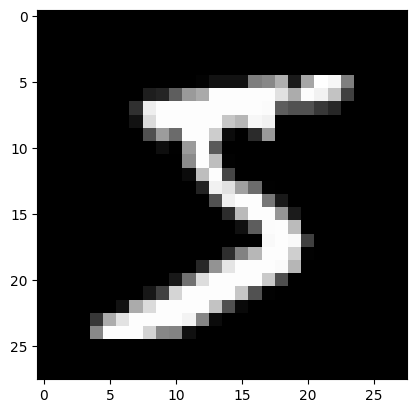

In [4]:
print(f"Dataset split: {len(data)} train rows")
print(f"Dataset split: {len(labels)} test rows")

point = data[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [5]:
train_data, train_labels, test_data, test_labels, test_true_labels, anom_data, anom_labels = utility.preprocess_data(data, labels, False)

In [6]:
print(train_data.shape)
print(test_data.shape)
print(anom_data.shape)

(56000, 784)
(10004, 784)
(4, 784)


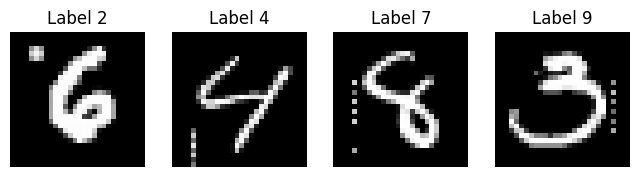

In [7]:
num_images = len(anom_data)
rows = 1
cols = num_images
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    
for i in range(num_images):
    axes[i].imshow(anom_data[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label {anom_labels[i]}")
    
plt.show()

In [8]:
# parameters
contamination = 0.0004
algorithm = 'auto'
leaf_size = 10
metric = 'euclidean'
n_neighbors = 5

In [9]:
# Create and fit a Local Outlier Factor model
model = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric, leaf_size=leaf_size, algorithm=algorithm, novelty=True)
model.fit(train_data, train_labels)

LocalOutlierFactor(contamination=0.0004, leaf_size=10, metric='euclidean',
                   n_neighbors=5, novelty=True)

In [10]:
# Get anomaly scores for training and test data
scores_train = model.decision_function(train_data)
scores_test = model.decision_function(test_data)

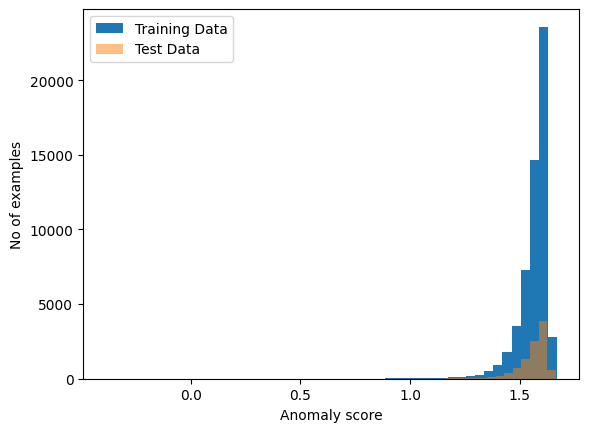

In [11]:
# Plot histograms of anomaly scores for training and test data
plt.hist(scores_train, bins=50, label='Training Data')
plt.hist(scores_test, bins=50, alpha=0.5, label='Test Data')
plt.xlabel("Anomaly score")
plt.ylabel("No of examples")
plt.legend()
plt.show()

In [12]:
# predict
preds = model.predict(test_data)

# Convert to boolean values
preds = [pred == 1 for pred in preds]

# Convert to numpy array
preds = np.array(preds)

In [13]:
# anomaly scores
anomaly_scores = model.decision_function(test_data)

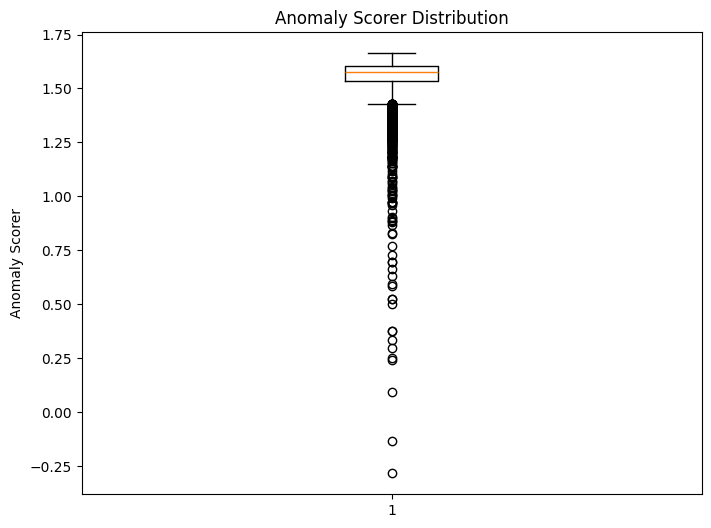

In [14]:
q1, q3, iqr, minimum, maximum = utility.boxplot_plot("Anomaly Scorer", anomaly_scores)

In [15]:
utility.print_boxplot(q1, q3, iqr, minimum, maximum)

Q1:  1.534
Q3:  1.604
IQR:  0.07
Minimum:  1.429
Maximum:  1.663


C:\Users\zippe\AppData\Local\Temp\ipykernel_22864\1167958668.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=['blue' if e > threshold else 'red' for e in anomaly_scores], cmap='coolwarm', marker='o', edgecolors='k')


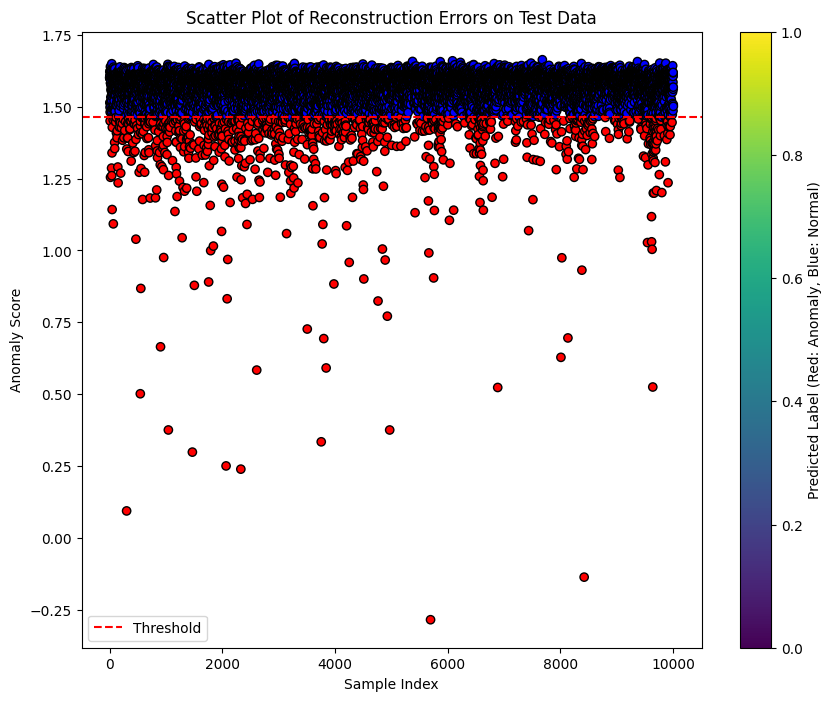

In [16]:
# Set a threshold for classifying anomalies
threshold = 0.0
threshold = np.mean(anomaly_scores) - np.std(anomaly_scores)
# Create a binary array indicating anomalies
anomaly_indicator = np.where(anomaly_scores > threshold, 1, 0)

# Scatter plot with anomalies and normal instances based on anomaly prediction and threshold
plt.figure(figsize=(10, 8))
scatter = plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=['blue' if e > threshold else 'red' for e in anomaly_scores], cmap='coolwarm', marker='o', edgecolors='k')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.colorbar(scatter, label='Predicted Label (Red: Anomaly, Blue: Normal)')
plt.show()

In [17]:
# Predict anomalies based on the custom threshold
preds = (anomaly_scores > threshold).astype(int)

# Convert labels from -1/1 to True/False
preds = preds == 1

In [18]:
a, p, r, f1, report, cm = utility.get_metrics(preds, test_true_labels)

In [19]:
utility.print_stats(a, p, r, f1, report, cm)

Accuracy = 0.909936025589764
Precision = 0.999670510708402
Recall = 0.9102
F1 = 0.9528395707929861
Report
               precision    recall  f1-score   support

     anomaly       0.00      0.25      0.00         4
      normal       1.00      0.91      0.95     10000

    accuracy                           0.91     10004
   macro avg       0.50      0.58      0.48     10004
weighted avg       1.00      0.91      0.95     10004

Confusion Matrix
[[   1    3]
 [ 898 9102]]


True Negatives: 1
False Positives: 3
False Negatives: 898
True Positives: 9102


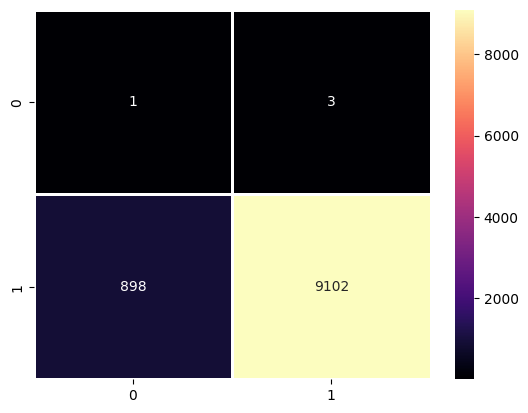

In [20]:
utility.create_heatmap(cm)

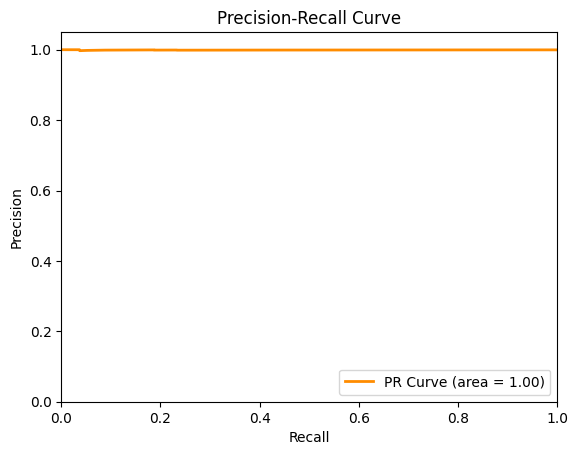

In [21]:
utility.pr_auc_plot(anomaly_scores, test_true_labels, True)

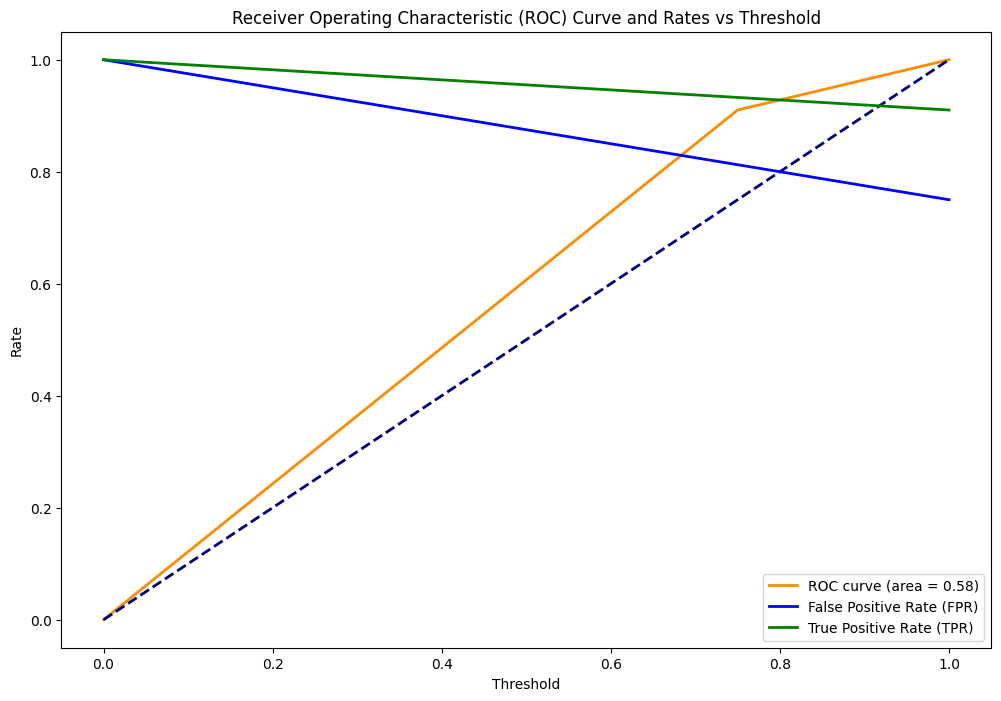

In [22]:
utility.roc_plot(preds, test_true_labels)

In [23]:
# Get anomaly scores for training and test data
scores_train = model.decision_function(train_data)
scores_test = model.decision_function(test_data)
scores_anom = model.decision_function(anom_data)

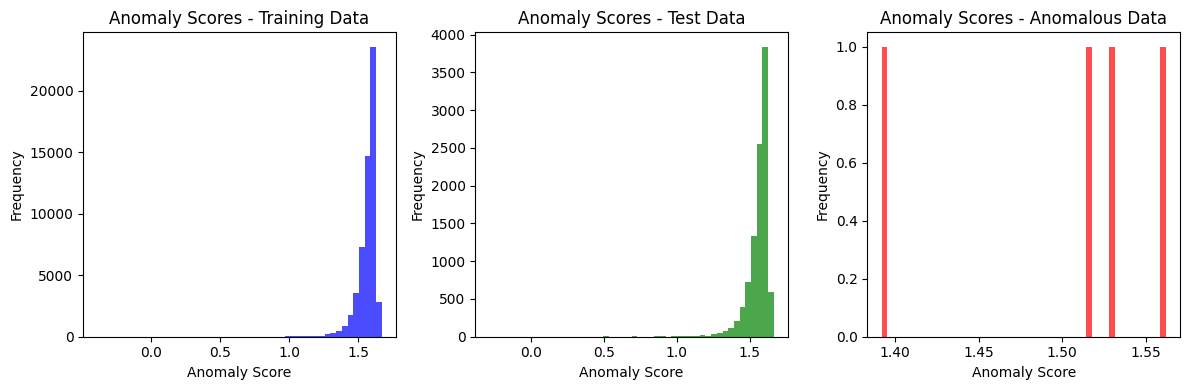

In [24]:
# Plotting histograms
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(scores_train, bins=50, color='blue', alpha=0.7)
plt.title('Anomaly Scores - Training Data')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(scores_test, bins=50, color='green', alpha=0.7)
plt.title('Anomaly Scores - Test Data')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(scores_anom, bins=50, color='red', alpha=0.7)
plt.title('Anomaly Scores - Anomalous Data')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [25]:
anomaly_indexes = utility.write_to_json(preds)

Anomaly indexes saved to .\anomalies.json


899


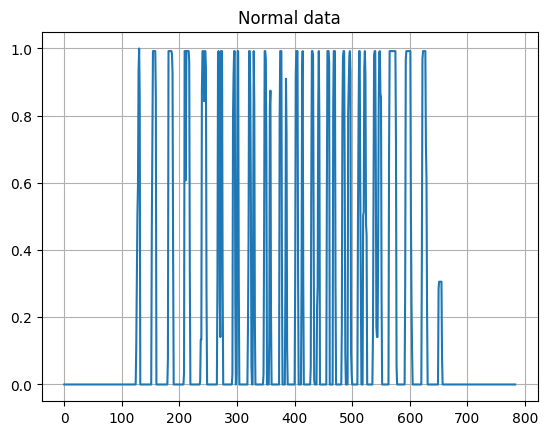

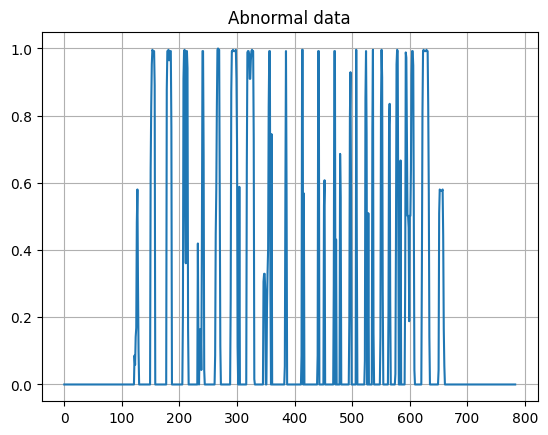

In [26]:
print(len(anomaly_indexes))

utility.plot_normalized_pixel_data(train_data, anom_data)

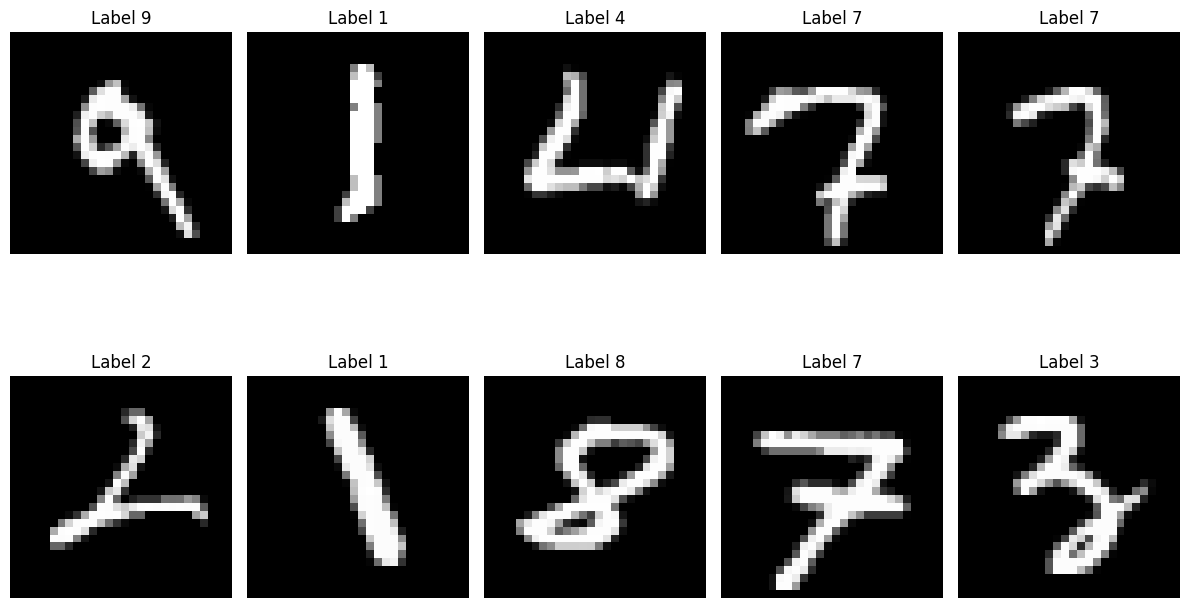

In [27]:
utility.plot_anomaly_imgs(anomaly_indexes, test_data, test_labels)

In [28]:
stop_thread = True

thread.join()
print(f"CPU Usage: {max_cpu_usage}%")
print(f"Memory Usage: {max_memory_usage}%")

CPU Usage: 31.0%
Memory Usage: 31.6%


In [29]:
end_time = utility.time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time} seconds")

Total execution time: 84.60216045379639 seconds
